<a href="https://colab.research.google.com/github/SatenikS/reddit-text-classification/blob/main/reddit-science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **r/Sciences Post Classification with Interpretability**


In this project I have created text classification models to classify Reddit posts  according to their topics. I use Local Interpretable Model-Agnostic Explanations ([lime](https://lime-ml.readthedocs.io/en/latest/index.html)) to generate explanations for the predictions.

[r/Sciences](https://www.reddit.com/r/sciences/) subreddit is a great community to share and discuss new scientific research and read about the latest advances in astronomy, biology, medicine, physics, social science, and more.

In [ ]:
# Imports necessary libraries
import numpy as np
import pandas as pd
from google.colab import drive
import os
import praw
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Changes directory to my Google Drive folder
drive.mount("/content/drive", force_remount=True)
os.chdir("/content/drive/My Drive/Colab Notebooks/Reddit/")

Mounted at /content/drive


In [ ]:
def add_or_update_posts(period="all", limit=1000):
    """Downloads and saves Reddit posts for a given period.

        Args:
            period (str): Can be one of the following – all, day, hour, month, week, year
            limit (int): Number of posts

        Returns:
            None
    """
    # Initializes a Reddit instance using provided credentials
    reddit = praw.Reddit(client_id="client_id",
                     client_secret="client_secret",
                     password="password",
                     user_agent="user_agent",
                     username="username")
    
    # Loads the 'raw.csv' file. If it does not exist creates one.
    if not os.path.isfile("raw.csv"):
        df = pd.DataFrame(columns=["id", "added_utc", "author.id", "author.name",
                                   "edited", "created_utc", "link_flair_text",
                                   "locked", "num_comments", "over_18", "permalink",
                                   "title", "score", "upvote_ratio"]) 
        df.to_csv("raw.csv", index=False)
    else:
        df = pd.read_csv("raw.csv")
  
    # Imports top posts from a subreddit called 'Science' 
    top_posts = reddit.subreddit("science").top(period, limit=limit)

    # Creates a list with the names of the columns of the dataframe
    cols = df.columns.tolist()

    # Appends all posts from top_posts if they are not present in the dataframe or have been edited since
    for post in top_posts:
        d = {}
        if post.id not in df["id"].values or post.edited > df.loc[df["id"] == post.id, "edited"].iloc[0]:
            for c in cols:
                try: d[c] = eval("post." + c)
                except: d[c] = None
            d["added_utc"] = round(time.time())
            df.drop(df[df["id"] == post.id].index, inplace=True)
            df = df.append(d, ignore_index=True)

    # Writes the dataframe to the csv file
    df.to_csv("raw.csv", index=False)

In [ ]:
# Downloads and saves top posts from the following periods – all/year/month/week 
for period in ["all", "year", "month", "week"]:
    add_or_update_posts(period=period, limit = 1000)

In [ ]:
# Loads all saved Reddit posts
df = pd.read_csv("raw.csv")

# Prints the number of posts and columns
df.shape

(3876, 14)

In [ ]:
# Prints the counts of the top 20 most common flairs/subjects
df["link_flair_text"].value_counts().head(20)

Psychology          603
Health              504
Biology             388
Medicine            365
Environment         327
Social Science      308
Neuroscience        212
Epidemiology        161
Physics             140
Astronomy           133
Animal Science      128
Anthropology         89
Chemistry            85
Engineering          83
Computer Science     62
Cancer               61
Economics            55
Paleontology         45
Earth Science        43
Nanoscience          32
Name: link_flair_text, dtype: int64

In [ ]:
# Remove all posts with subjects that have less than 100 posts
unique_flairs = df["link_flair_text"].value_counts()
df = df[df["link_flair_text"].isin(unique_flairs.index[unique_flairs>100])]

In [ ]:
# Prints the counts of remaining subjects
df["link_flair_text"].value_counts()

Psychology        603
Health            504
Biology           388
Medicine          365
Environment       327
Social Science    308
Neuroscience      212
Epidemiology      161
Physics           140
Astronomy         133
Animal Science    128
Name: link_flair_text, dtype: int64

In [ ]:
# Prints the average upvote ratio for each subject
df.groupby("link_flair_text")["upvote_ratio"].mean().sort_values(ascending=False)

link_flair_text
Neuroscience      0.869104
Animal Science    0.863984
Environment       0.859511
Psychology        0.856534
Health            0.849028
Medicine          0.845233
Biology           0.844201
Astronomy         0.836466
Epidemiology      0.826398
Physics           0.826143
Social Science    0.823344
Name: upvote_ratio, dtype: float64

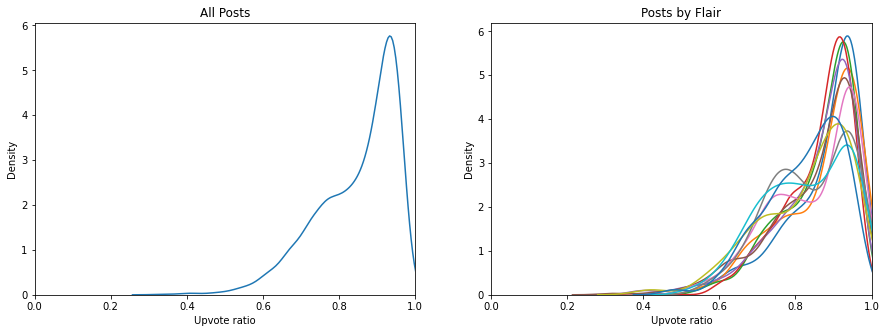

In [ ]:
# Plots the distributions of upvote ratios by subject
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
g1 = sns.kdeplot(df["upvote_ratio"], label="", ax=axs[0])  
for flair in df.groupby("link_flair_text")["upvote_ratio"].mean().sort_values(ascending=False).index.tolist():
    g2 = sns.kdeplot(df.loc[df["link_flair_text"] == flair, "upvote_ratio"], label=flair, ax=axs[1])  
g1.set(xlim=(0,1), title="All Posts", xlabel="Upvote ratio", ylabel="Density")
g2.set(xlim=(0,1), title="Posts by Flair", xlabel="Upvote ratio", ylabel="Density")
fig.show()